In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kshort_pn_4GeV_Jun2_ntuple/*.root")

In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x



In [4]:
def track_smear(kinetic_energy, theta):
    # assume flat uncertainty on the energy (I think that is 6%)
    c_eres = random.gauss(1.,0.06); # flat 10% uncertainty for now
    # assume some uncertainty on the angle (I think that is 2%)
    c_hres = random.gauss(0.,0.02); # 1 degrees
    return (c_eres*kinetic_energy, abs(c_hres+theta))

In [5]:
hists = {}
hists["Target_pion_ke"] = hist.Hist("Target SP Kaons",    
                                hist.Bin("keOG", r"Kinetic Energy [MeV]", 80, 0, 2000),
                                hist.Bin("keS", r"Energy [MeV]", 80, 0, 2000),
                            )       
hists["Target_pion_theta"] = hist.Hist("Target SP Kaons",    
                                hist.Bin("keOG", r"$\theta [^{\circ}]$", 80, 0, 4),
                                hist.Bin("keS", r"$\theta [^{\circ}]$", 80, 0, 4),
                            ) 
hists["Target_pion_mass"] = hist.Hist("Target SP Kaons",    
                                hist.Bin("keOG", r"Mass [MeV]", 80, 0, 300),
                                hist.Bin("keS", r"Mass [MeV]", 80, 0, 300),
                            )      

In [6]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)

    target_kaon_dau1 = ldmx_events['TSP_Kaon_dau1']
    target_kaon_dau2 = ldmx_events['TSP_Kaon_dau2']
    
    kshort_pdgid = 310
    chargedpion_pdgid = 211
    pion_mass = 139
    
    mask_2dau1 = (target_kaon_dau1.gd==0)
    mask_2dau2 = (target_kaon_dau2.gd==0)
    kshort_mask = (abs(target_kaon_dau1.mompdgID)==kshort_pdgid)
    pidau1_mask = (abs(target_kaon_dau1.pdgID)==chargedpion_pdgid)
    pidau2_mask = (abs(target_kaon_dau2.pdgID)==chargedpion_pdgid)

 
    pi1 = get_vector(target_kaon_dau1[pidau1_mask & kshort_mask & mask_2dau1])
    pi2 = get_vector(target_kaon_dau2[pidau2_mask & kshort_mask & mask_2dau2])
    
    new_ke1 = track_smear(pi1.t - pi2.mass, pi1.theta)[0]
    new_ke2 = track_smear(pi2.t - pi2.mass, pi2.theta)[0]
    new_theta1 = track_smear(pi1.t - pi1.mass, pi1.theta)[1]
    new_theta2 = track_smear(pi2.t - pi2.mass, pi2.theta)[1]
    
    
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)


    pi1_track_smeared =  ak.zip({"x": pi1.rho*np.cos(pi1.phi)*np.sin(new_theta1),
                    "y": pi1.rho*np.sin(new_theta1)*np.sin(pi1.phi),
                    "z": pi1.rho*np.cos(new_theta1),
                    "t": new_ke1,
                    },
                    with_name="LorentzVector")
    pi2_track_smeared =  ak.zip({"x": pi2.rho*np.cos(pi2.phi)*np.sin(new_theta2),
                    "y": pi2.rho*np.sin(new_theta2)*np.sin(pi2.phi),
                    "z": pi2.rho*np.cos(new_theta2),
                    "t": new_ke2,
                    },
                    with_name="LorentzVector")
    pi_smeared_sum = (pi1_track_smeared+pi2_track_smeared)
    
    pisum = (pi1+pi2)
    
    

    
    print(pi_smeared_sum)
    print(pisum)
    #print(pi_smeared_sum.mass)
    
    
    #print('theta ',pi1.theta)
    #print('smeared_ theta ',new_theta1)
    #print('x',pi1.px)
    #print('smeared_x',pi1.rho*np.cos(pi1.phi)*np.sin(new_theta1))
    #print('y',pi1.py)
    #print('smeared_y',pi1.rho*np.sin(new_theta1)*np.sin(pi1.phi))
    #print('z ',pi1.z)
    #print('smeared_z ',pi1.rho*np.cos(new_theta1))  
    
    hists["Target_pion_ke"].fill(
                                 keOG=flat((pi2).t - pion_mass),
                                 keS=flat((pi2_track_smeared).t),
                                )
    hists["Target_pion_theta"].fill(
                                 keOG=flat(pi2.theta),
                                 keS=flat(pi2_track_smeared.theta),
                                )
    hists["Target_pion_mass"].fill(
                                 keOG=flat(pi2.mass),
                                 keS=flat(pi2.t-pi2_track_smeared.t),
                                )
    
    
    return

In [7]:
nchunk = 0
for chunk in ldmx_dict:
    #if nchunk >= 1: break
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)

process 1
[[], [{x: -321, y: 392, z: 1.06e+03, t: 991}, ... y: 126, z: 1.04e+03, t: 873}]]
[[], [{x: -322, y: 367, z: 1.08e+03, ... y: 154, z: 1.04e+03, t: 1.16e+03}]]
process 2
[[{x: -454, y: -102, z: 704, t: 651}], ... y: 533, z: 2.34e+03, t: 2.1e+03}]]
[[{x: -445, y: -99.3, z: 711, t: 973}], ... y: 511, z: 2.35e+03, t: 2.51e+03}]]
process 3
[[], [{x: 29.3, y: -239, z: 70, t: 261}], ... y: 15.3, z: 42.9, t: 234}], [], []]
[[], [{x: 29.3, y: -239, z: 68.2, t: 550}], ... z: 41.3, t: 523}], [], []]
process 4
[[{x: 181, y: -314, z: 1.34e+03, t: 1.2e+03}], ... z: 1.18e+03, t: 1.03e+03}], []]
[[{x: 184, y: -306, z: 1.34e+03, t: 1.47e+03}], ... z: 1.18e+03, t: 1.3e+03}], []]
process 5
[[], [{x: 697, y: 194, z: 2.33e+03, t: 2.24e+03}], ... z: 424, t: 528}], [], []]
[[], [{x: 716, y: 193, z: 2.32e+03, t: 2.48e+03}], ... z: 422, t: 783}], [], []]
process 6
[[], [{x: 185, y: 287, z: 925, t: 741}], ... y: -305, z: 947, t: 857}], []]
[[], [{x: 189, y: 302, z: 915, t: 1.1e+03}], ... y: -304, z: 94

<Hist (keOG,keS) instance at 0x10ba97b20>


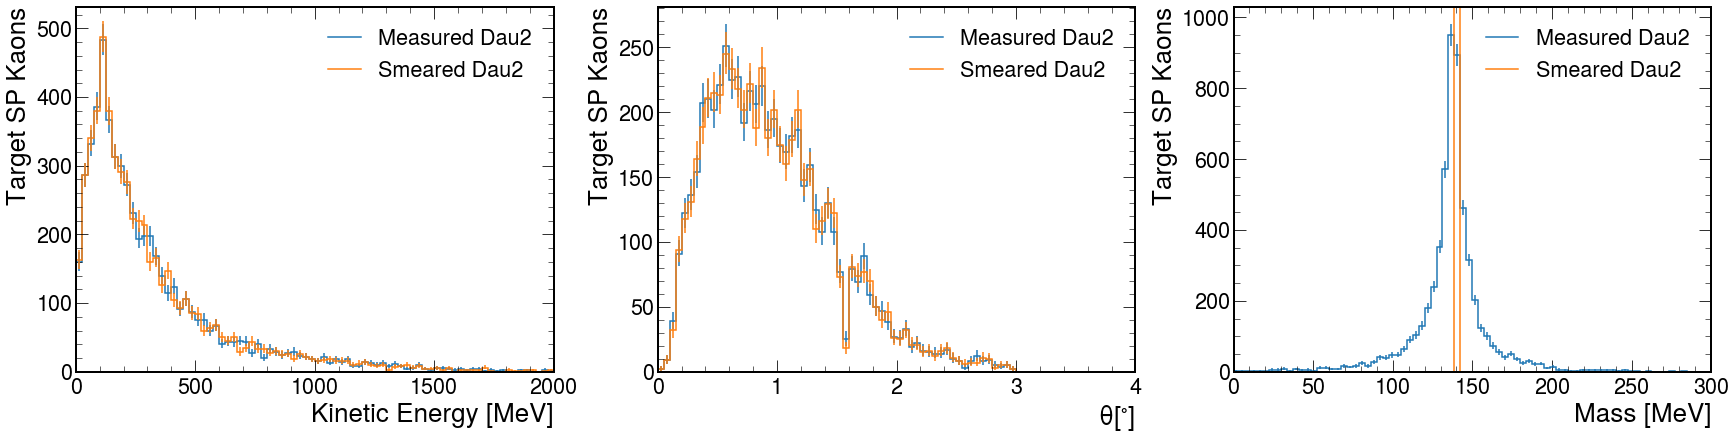

In [11]:
print(hists["Target_pion_ke"])
fig, ax = plt.subplots(1,3,figsize=(24,6), constrained_layout=True)
hist.plot1d(hists["Target_pion_ke"].sum('keOG'),ax=ax[0],clear=False);
hist.plot1d(hists["Target_pion_ke"].sum('keS'),ax=ax[0],clear=False);
leg = ax[0].legend([r'Measured Dau2', r'Smeared Dau2'])

hist.plot1d(hists["Target_pion_theta"].sum('keOG'),ax=ax[1],clear=False);
hist.plot1d(hists["Target_pion_theta"].sum('keS'),ax=ax[1],clear=False);
leg = ax[1].legend([r'Measured Dau2', r'Smeared Dau2'])

hist.plot1d(hists["Target_pion_mass"].sum('keOG'),ax=ax[2],clear=False);
hist.plot1d(hists["Target_pion_mass"].sum('keS'),ax=ax[2],clear=False);
leg = ax[2].legend([r'Measured Dau2', r'Smeared Dau2'])

<Hist (keOG,keS) instance at 0x10ba97fa0>


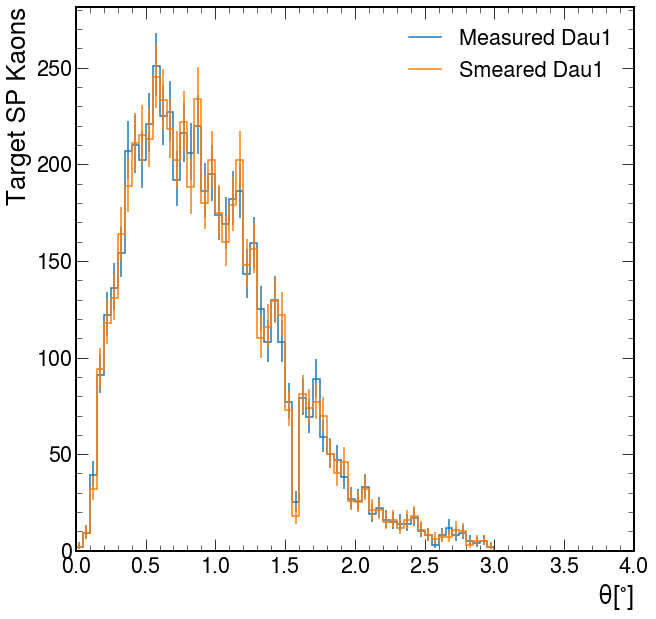

In [9]:
print(hists["Target_pion_theta"])
fig, ax = plt.subplots()
hist.plot1d(hists["Target_pion_theta"].sum('keOG'),ax=ax,clear=False);
hist.plot1d(hists["Target_pion_theta"].sum('keS'),ax=ax,clear=False);
leg = ax.legend([r'Measured Dau1', r'Smeared Dau1'])

<Hist (keOG,keS) instance at 0x10ba975e0>


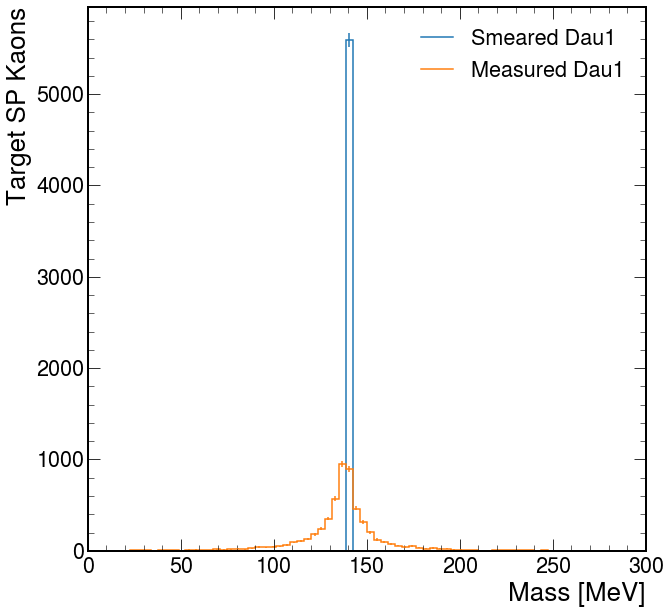

In [10]:
print(hists["Target_pion_mass"])
fig, ax = plt.subplots()
hist.plot1d(hists["Target_pion_mass"].sum('keS'),ax=ax,clear=False);
hist.plot1d(hists["Target_pion_mass"].sum('keOG'),ax=ax,clear=False);
leg = ax.legend([r'Smeared Dau1', r'Measured Dau1'])